In [1]:
# package load
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display

In [2]:
!git clone https://github.com/KU-DIC/LG_time_series_day14.git

Cloning into 'LG_time_series_day14'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 32 (delta 6), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (32/32), done.


In [3]:
# load the dataset
df = pd.read_csv("/content/LG_time_series_day14/sensor-filtered.csv")
df.head(3)

,timestamp,sensor_04,sensor_06,sensor_07,sensor_08,sensor_09,machine_status
0,2018-04-01 00:00:00,634.3750,13.41146,16.13136,15.56713,15.05353,0
1,2018-04-01 00:01:00,634.3750,13.41146,16.13136,15.56713,15.05353,0
2,2018-04-01 00:02:00,638.8889,13.32465,16.03733,15.61777,15.01013,0


In [4]:
# anomalies
broken = df[df['machine_status']==1]
display(broken.head(10))

,timestamp,sensor_04,sensor_06,sensor_07,sensor_08,sensor_09,machine_status
17155,2018-04-12 21:55:00,202.526031,3.219039,16.89091,16.869210,15.082470,1
17156,2018-04-12 21:56:00,204.725098,3.045428,17.42621,15.740740,16.174770,1
17157,2018-04-12 21:57:00,201.137131,7.537616,13.53443,9.324364,16.051790,1
17158,2018-04-12 21:58:00,204.030655,7.609953,16.60880,16.203700,16.095200,1
17159,2018-04-12 21:59:00,203.567688,7.573785,16.70284,16.160300,16.087960,1
17160,2018-04-12 22:00:00,203.567688,7.559317,16.56539,16.239870,16.051790,1
17161,2018-04-12 22:01:00,203.567688,7.559317,16.56539,16.239870,16.051790,1
17162,2018-04-12 22:02:00,202.988983,7.537616,16.56539,16.160300,16.095200,1
17163,2018-04-12 22:03:00,201.947327,3.920717,16.52199,16.030090,16.095196,1
17164,2018-04-12 22:04:00,201.252869,6.510417,16.70284,15.950520,16.095200,1


In [5]:
# Continuous columns filtering
df2 = df.drop(['machine_status'], axis=1)
display(df2.head(10))

,timestamp,sensor_04,sensor_06,sensor_07,sensor_08,sensor_09
0,2018-04-01 00:00:00,634.3750,13.41146,16.13136,15.56713,15.05353
1,2018-04-01 00:01:00,634.3750,13.41146,16.13136,15.56713,15.05353
2,2018-04-01 00:02:00,638.8889,13.32465,16.03733,15.61777,15.01013
3,2018-04-01 00:03:00,628.1250,13.31742,16.24711,15.69734,15.08247
4,2018-04-01 00:04:00,636.4583,13.35359,16.21094,15.69734,15.08247
5,2018-04-01 00:05:00,637.6157,13.41146,16.16753,15.89265,15.16204
6,2018-04-01 00:06:00,633.3333,13.43316,16.13136,15.65393,15.08247
7,2018-04-01 00:07:00,630.6713,13.25231,16.12413,16.19647,15.08247
8,2018-04-01 00:08:00,631.9444,13.28848,16.13136,15.47309,15.11863
9,2018-04-01 00:09:00,641.7823,13.38252,16.24711,15.61777,15.11863


In [15]:
names = df2.iloc[:,1:].columns
names

Index(['sensor_04', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09'], dtype='object')

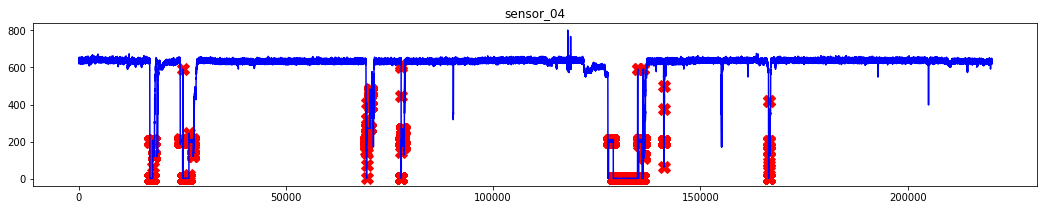

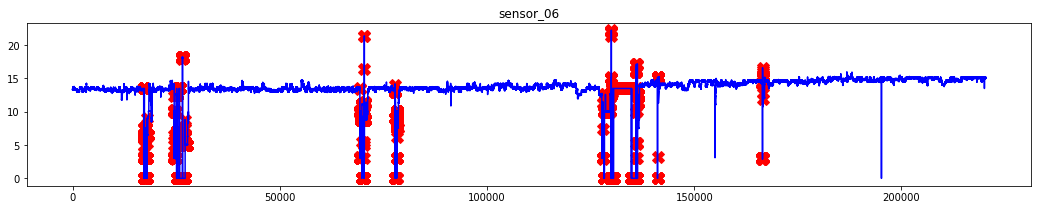

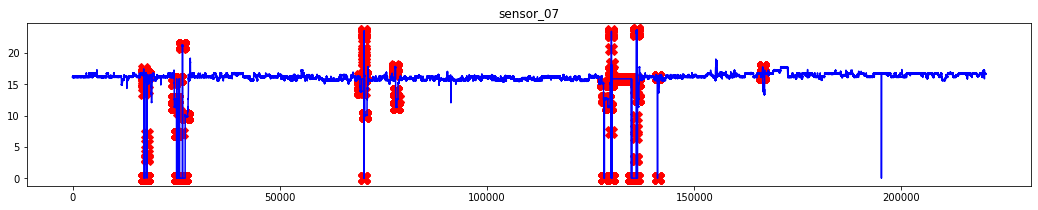

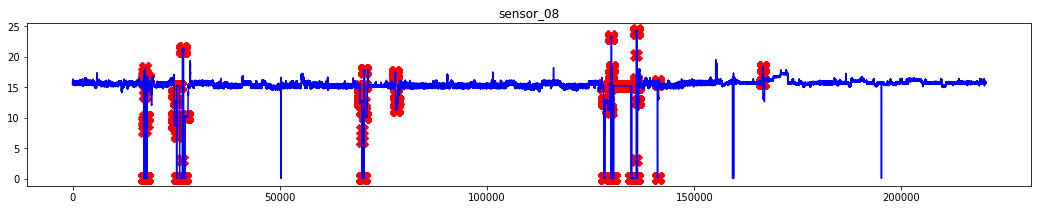

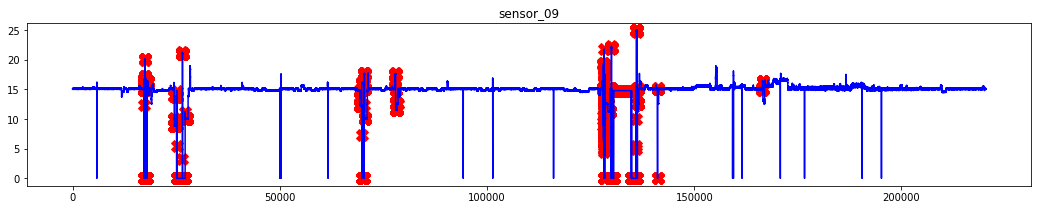

In [11]:
# 빨간색으로 X로 표시된 BROKEN 상태의 각 센서에 대한 시계열 플롯
for name in names:
    _ = plt.figure(figsize=(18,3))
    _ = plt.plot(broken[name], linestyle='none', marker='X', color='red', markersize=12)
    _ = plt.plot(df[name], color='blue')
    _ = plt.title(name)
    plt.show()

In [16]:
# Data normalization from standard scaler
from sklearn.preprocessing import StandardScaler

df2 = df.drop(['machine_status'], axis=1)
names = df2.iloc[:,1:].columns
x = df[names]

In [17]:
scaler = StandardScaler()

x = scaler.fit_transform(x)
x

array([[ 0.303443  , -0.04209145,  0.13258569,  0.18196391,  0.12285839],
       [ 0.303443  , -0.04209145,  0.13258569,  0.18196391,  0.12285839],
       [ 0.33478575, -0.08265609,  0.08932864,  0.20711247,  0.1018925 ],
       ...,
       [ 0.2447758 ,  0.74211773,  0.39548621,  0.24662809,  0.15430723],
       [ 0.3122829 ,  0.75563616,  0.33225446,  0.26818117,  0.15430723],
       [ 0.34121483,  0.75563616,  0.37219006,  0.22507006,  0.1018925 ]])

In [18]:
# outlier fraction check
ture_anomaly_proportion = df['machine_status'].value_counts()[1] / sum(df['machine_status'].value_counts())
print(ture_anomaly_proportion)

# Assume that 6.5% of the entire data set are anomalies 
outliers_fraction = 0.06574

0.06574074074074074


In [19]:
!pip install adtk

     |████████████████████████████████| 60 kB 5.5 MB/s 


In [20]:
# Isolation Forest model define & train
from sklearn.ensemble import IsolationForest
from adtk.visualization import plot

model =  IsolationForest(contamination = outliers_fraction)
model.fit(x)

IsolationForest(contamination=0.06574)

In [21]:
# anomaly score 계산
scores = model.score_samples(x)
scores

array([-0.33989476, -0.33989476, -0.34543653, ..., -0.37858405,
       -0.37240755, -0.38078174])

In [22]:
df['anomaly_scores'] = model.score_samples(x)
df['anomaly_scores']

0        -0.339895
1        -0.339895
2        -0.345437
3        -0.343102
4        -0.342277
            ...   
220315   -0.371573
220316   -0.374682
220317   -0.378584
220318   -0.372408
220319   -0.380782
Name: anomaly_scores, Length: 220320, dtype: float64

In [23]:
df['anomaly_classification'] = model.predict(x)
df['anomaly_classification']

0         1
1         1
2         1
3         1
4         1
         ..
220315    1
220316    1
220317    1
220318    1
220319    1
Name: anomaly_classification, Length: 220320, dtype: int64

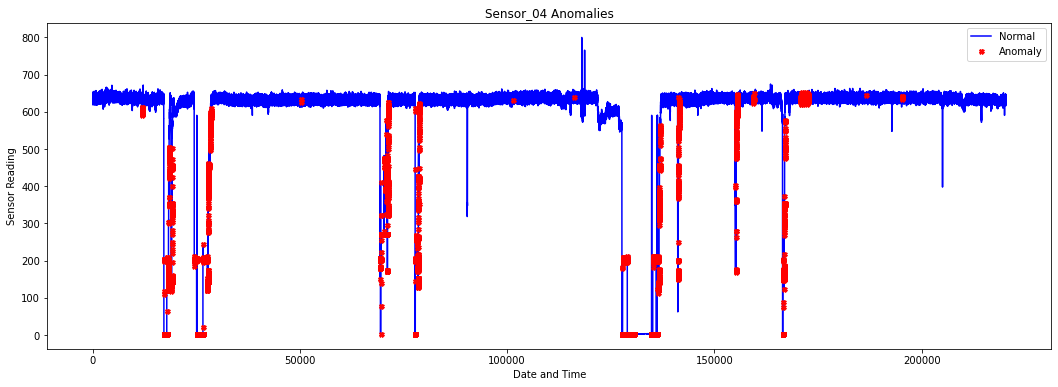

In [24]:
# visualization (Isolation Forest 모델링 결과 이상치로 분류된 instance)
a = df.loc[df['anomaly_classification'] == -1] 
_ = plt.figure(figsize=(18,6))
_ = plt.plot(df['sensor_04'], color='blue', label='Normal')
_ = plt.plot(a['sensor_04'], linestyle='none', marker='X', color='red', markersize=5, label='Anomaly')
_ = plt.xlabel('Date and Time')
_ = plt.ylabel('Sensor Reading')
_ = plt.title('Sensor_04 Anomalies')
_ = plt.legend(loc='best')
plt.show()

In [25]:
# Detection performance check
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f} 재현율: {2:.4f}, F1: {3:.4f}'.format(accuracy, precision, recall, f1))

In [26]:
df['anomaly_classification'] = np.where(df['anomaly_classification'] == -1, 1, 0)
get_clf_eval(df['machine_status'], df['anomaly_classification'])

오차 행렬
[[201233   4603]
 [  4603   9881]]
정확도: 0.9582, 정밀도: 0.6822 재현율: 0.6822, F1: 0.6822
